# Configuration

In [1]:
# Parameters
PROJECT_NAME = 'ML1010-Group-Project'
ENABLE_COLAB = False

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni//ML_Root/project_root'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Wha...where am I?
I am awake now.

I have set your current working directory to /home/magni/ML_Root/project_root/ML1010-Group-Project
The current time is 13:32
Hello sir. Reminder, no more coffee.



# Setup Runtime Environment

In [3]:
if ENABLE_COLAB:
  #!pip install scipy -q
  #!pip install scikit-learn -q
  #!pip install pycaret -q
  #!pip install matplotlib -q
  #!pip install joblib -q
  #!pip install pandasql -q

  display('Google Colab enabled')
else:
  display('Google Colab not enabled')

#Common imports
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import re
import nltk
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
nltk.download('stopwords')
%matplotlib inline

'Google Colab not enabled'

[nltk_data] Downloading package stopwords to /home/magni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import necessary depencencies

In [4]:
import pandas as pd
import numpy as np
import text_normalizer as tn
from tensorflow import keras
#import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

2022-01-11 13:32:23.061281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-11 13:32:23.061307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load and normalize data

In [5]:
dataset = pd.read_csv(r'/home/magni/ML_Root/project_root/data/ML1010_Weekly/movie_reviews_cleaned.csv')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
#train_reviews = reviews[:35000]
#train_sentiments = sentiments[:35000]
#test_reviews = reviews[35000:]
#test_sentiments = sentiments[35000:]

train_reviews = reviews[:5000]
train_sentiments = sentiments[:5000]
test_reviews = reviews[5000:]
test_sentiments = sentiments[5000:]



# normalize datasets
#norm_train_reviews = tn.normalize_corpus(train_reviews)
#norm_test_reviews = tn.normalize_corpus(test_reviews)
norm_train_reviews = train_reviews
norm_test_reviews = test_reviews

                                              review sentiment
0  not bother think would see movie great supspen...  negative
1  careful one get mitt change way look kung fu f...  positive
2  chili palmer tired movie know want success mus...  negative
3  follow little know 1998 british film make budg...  positive
4  dark angel cross huxley brave new world percys...  positive


In [6]:
print(train_sentiments)
print(test_sentiments)

['negative' 'positive' 'negative' ... 'positive' 'negative' 'negative']
['negative' 'negative' 'negative' ... 'negative' 'positive' 'negative']


# Tokenize train & test datasets

In [7]:
from nltk.tokenize import word_tokenize
#word_tokenize(text)

tokenized_train = [word_tokenize(text) for text in norm_train_reviews]
tokenized_test = [word_tokenize(text) for text in norm_test_reviews]

In [26]:
print(len(tokenized_train))
print(len(tokenized_test))
print(len(norm_test_reviews))

5000
45000
45000


# Build Vocabulary Mapping (word to index)

In [8]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 32182
Sample slice of vocabulary map: {'boring': 11, 'terribly': 12, 'predictable': 13, 'interesting': 14, 'start': 15, 'middle': 16, 'film': 17, 'little': 18, 'social': 19, 'drama': 20}


# Encode and Pad datasets & Encode prediction class labels

In [9]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# get max length of train corpus and initialize label encoder
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
#train_y = le.fit_transform(train_sentiments)
train_y = le.fit_transform(train_sentiments)


## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 627
Train review vectors shape: (5000, 627)  Test review vectors shape: (45000, 627)


# Build the LSTM Model Architecture

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

2022-01-11 13:32:41.472754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 13:32:41.472792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 13:32:41.472808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-01-11 13:32:41.473043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 627, 128)          4119296   
                                                                 
 spatial_dropout1d (SpatialD  (None, 627, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,168,769
Trainable params: 4,168,769
Non-trainable params: 0
_________________________________________________________________
None


# Visualize model architecture

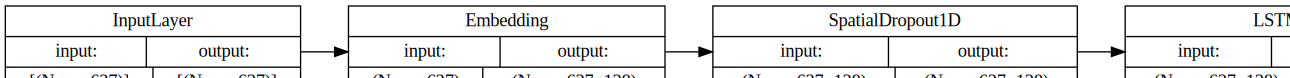

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

# Train the model

In [13]:
batch_size = 100
history = model.fit(train_X,
          train_y,
          epochs=5,
          batch_size=batch_size, 
          shuffle=True,
          validation_split=0.1,
          verbose=1)

Epoch 1/5
45/45 [==============================] - 21s 420ms/step - loss: 0.6536 - accuracy: 0.6658 - val_loss: 0.5803 - val_accuracy: 0.7560
Epoch 2/5
45/45 [==============================] - 18s 392ms/step - loss: 0.3688 - accuracy: 0.8682 - val_loss: 0.3769 - val_accuracy: 0.8300
Epoch 3/5
45/45 [==============================] - 18s 407ms/step - loss: 0.1635 - accuracy: 0.9484 - val_loss: 0.3444 - val_accuracy: 0.8520
Epoch 4/5
45/45 [==============================] - 18s 396ms/step - loss: 0.0721 - accuracy: 0.9818 - val_loss: 0.4656 - val_accuracy: 0.8380
Epoch 5/5
45/45 [==============================] - 18s 404ms/step - loss: 0.0318 - accuracy: 0.9936 - val_loss: 0.4996 - val_accuracy: 0.8220


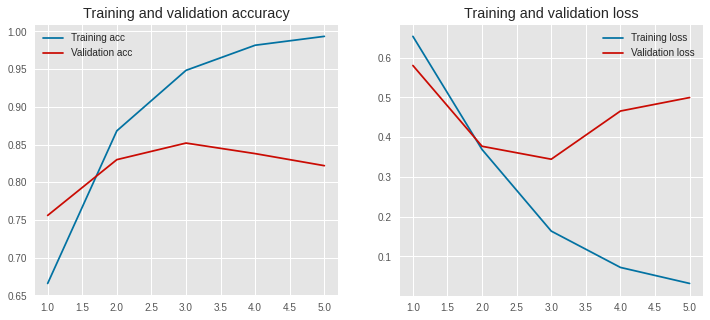

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Predict and Evaluate Model Performance

In [16]:
pred_test = model.predict(test_X)

In [21]:
pred_test = np.round(pred_test).astype(int)

pred_test_flat = pred_test.flatten()
print(pred_test_flat)
print(len(pred_test_flat))
print(len(test_X))

[0 0 1 ... 0 1 0]
45000
45000


In [18]:
predictions = le.inverse_transform(pred_test.flatten())

In [23]:
import model_evaluation_utils as meu
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions,
                                      classes=['positive', 'negative'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8497
Precision: 0.8497
Recall: 0.8497
F1 Score: 0.8497

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.85      0.84      0.85     22497
    negative       0.85      0.85      0.85     22503

    accuracy                           0.85     45000
   macro avg       0.85      0.85      0.85     45000
weighted avg       0.85      0.85      0.85     45000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive      19000     3497
        negative       3266    19237
